# Lab 3: Weight Pruning Against Backdoored DNNs

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import keras
import sys
import h5py
import numpy as np

clean_data_filename = str(sys.argv[0])
poisoned_data_filename = str(sys.argv[1])
model_filename = str(sys.argv[2])

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def eval(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model):
    
    # bd_model = keras.models.load_model(model_filename)
    bd_model = model

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    # print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    # print('Attack Success Rate:', asr)

    return clean_accuracy, asr, cl_label_p, bd_label_p

In [8]:
from tensorflow import keras

cl = r'C:\Users\seyda\Desktop\labs\Lab3\data\valid.h5'
bd = r'C:\Users\seyda\Desktop\labs\Lab3\data\bd_valid.h5'
modelname = r'C:\Users\seyda\Desktop\labs\Lab3\models\bd_net.h5'

cl_x_test, cl_y_test = data_loader(cl)
bd_x_test, bd_y_test = data_loader(bd)
model = keras.models.load_model(modelname)
model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')

eval(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model)

(98.64899974019225,
 100.0,
 array([  43,  328,  196, ..., 1265,  845,  881], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

### Method1: Sorting based on the Sums

In [9]:
def prune_model(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model, x):

  weights = model.layers[5].get_weights()[0] # not sorted for now
  bias = model.layers[5].get_weights()[1] # not sorted for now

  norms = np.zeros((60))
  for i in range(60):
    norms[i] = np.sum(np.asarray(weights[:,:,:,i]))

  sorted_idx = np.argsort(norms)

  c_acc = np.zeros((60,1))
  bd_acc = np.zeros((60,1))
  pred_ca = np.zeros((cl_y_test.shape[0], 60))
  pred_bd = np.zeros((cl_y_test.shape[0], 60))


  c_acc[0], bd_acc[0], pred_ca[:,0], pred_bd[:,0] = eval(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model)

  for i in range(60):
    weights[:,:,:,sorted_idx[i]] = np.zeros((3,3,40))

    model.layers[5].set_weights(list([weights, bias]))
    print('iteration: ', i, '(pruned channel: ', sorted_idx[i], ')')
    c_acc[i], bd_acc[i], pred_ca[:,i], pred_bd[:,i] = eval(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model);
    print('CA: ', c_acc[i], 'ASR: ', bd_acc[i], '\n')

    if c_acc[i] < c_acc[0] - x:
      break;

    

  return c_acc, bd_acc, pred_bd[:,i]

In [10]:
c_acc, bd_acc, bd_labels = prune_model(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model, 100)

iteration:  0 (pruned channel:  29 )
CA:  [98.40651251] ASR:  [100.] 

iteration:  1 (pruned channel:  1 )
CA:  [98.20732658] ASR:  [100.] 

iteration:  2 (pruned channel:  51 )
CA:  [98.19000606] ASR:  [100.] 

iteration:  3 (pruned channel:  44 )
CA:  [98.19000606] ASR:  [100.] 

iteration:  4 (pruned channel:  32 )
CA:  [98.1813458] ASR:  [100.] 

iteration:  5 (pruned channel:  6 )
CA:  [98.16402529] ASR:  [100.] 

iteration:  6 (pruned channel:  59 )
CA:  [98.16402529] ASR:  [100.] 

iteration:  7 (pruned channel:  2 )
CA:  [98.16402529] ASR:  [100.] 

iteration:  8 (pruned channel:  19 )
CA:  [98.06876245] ASR:  [100.] 

iteration:  9 (pruned channel:  40 )
CA:  [98.06876245] ASR:  [100.] 

iteration:  10 (pruned channel:  23 )
CA:  [98.06876245] ASR:  [100.] 

iteration:  11 (pruned channel:  36 )
CA:  [98.06876245] ASR:  [100.] 

iteration:  12 (pruned channel:  47 )
CA:  [98.06876245] ASR:  [100.] 

iteration:  13 (pruned channel:  27 )
CA:  [98.06876245] ASR:  [100.] 

iterat

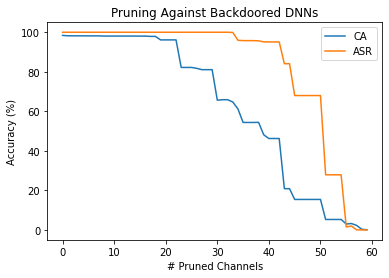

In [18]:
x = np.arange(60)
y1 = c_acc
y2 = bd_acc

plt.plot(x, y1, label = "CA")
plt.plot(x, y2, label = "ASR")

plt.xlabel('# Pruned Channels')
plt.ylabel('Accuracy (%)')
plt.title('Pruning Against Backdoored DNNs')

plt.legend()
plt.show()

### Method 2: Sorting based on norms

In [20]:
model = keras.models.load_model(modelname)
model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')


def prune_model2(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model, x):

  weights = model.layers[5].get_weights()[0] # not sorted for now
  bias = model.layers[5].get_weights()[1] # not sorted for now

  norms = np.zeros((60))
  for i in range(60):
    norms[i] = np.linalg.norm(np.asarray(weights[:,:,:,i]))

  sorted_idx = np.argsort(norms)

  c_acc = np.zeros((60,1))
  bd_acc = np.zeros((60,1))
  pred_ca = np.zeros((cl_y_test.shape[0], 60))
  pred_bd = np.zeros((cl_y_test.shape[0], 60))


  c_acc[0], bd_acc[0], pred_ca[:,0], pred_bd[:,0] = eval(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model)

  for i in range(60):
    weights[:,:,:,sorted_idx[i]] = np.zeros((3,3,40))

    model.layers[5].set_weights(list([weights, bias]))
    print('iteration: ', i, '(pruned channel: ', sorted_idx[i], ')')
    c_acc[i], bd_acc[i], pred_ca[:,i], pred_bd[:,i] = eval(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model);
    print('CA: ', c_acc[i], 'ASR: ', bd_acc[i], '\n')

    if c_acc[i] < c_acc[0] - x:
      break;

    

  return c_acc, bd_acc, pred_bd[:,i]

In [21]:
c_acc2, bd_acc2, bd_labels2 = prune_model2(cl_x_test, cl_y_test, bd_x_test, bd_y_test, model, 100)

iteration:  0 (pruned channel:  17 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  1 (pruned channel:  24 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  2 (pruned channel:  53 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  3 (pruned channel:  50 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  4 (pruned channel:  38 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  5 (pruned channel:  0 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  6 (pruned channel:  14 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  7 (pruned channel:  41 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  8 (pruned channel:  48 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  9 (pruned channel:  31 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  10 (pruned channel:  34 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  11 (pruned channel:  33 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  12 (pruned channel:  49 )
CA:  [98.64899974] ASR:  [100.] 

iteration:  13 (pruned channel:  45 )
CA:  [98.64899974] ASR:  [100.] 

ite

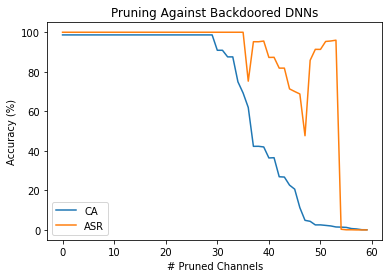

In [22]:
x = np.arange(60)
y1 = c_acc2
y2 = bd_acc2

plt.plot(x, y1, label = "CA")
plt.plot(x, y2, label = "ASR")

plt.xlabel('# Pruned Channels')
plt.ylabel('Accuracy (%)')
plt.title('Pruning Against Backdoored DNNs')

plt.legend()
plt.show()

In [23]:
# store_c_acc = c_acc
# store_c_acc2 = c_acc2
# store_bd_acc = bd_acc
# store_bd_acc2 = bd_acc2

### Repair

In [86]:
repair_index = np.zeros((4,))

for i in range(60):
    if repair_index[0] == 0 and c_acc[i] < c_acc[0] - 2:
        repair_index[0] = i

    elif repair_index[1] == 0 and c_acc[i] < c_acc[0] - 4:
        repair_index[1] = i

    elif repair_index[2] == 0 and c_acc[i] < c_acc[0] - 10:
        repair_index[2] = i

    elif repair_index[3] == 0 and c_acc[i] < c_acc[0] - 30:
        repair_index[3] = i

    if sum(repair_index == 0) == 0:
        break
repair_index = repair_index.astype(int)
print(repair_index)
        


[19 23 24 30]


### Pruned Networks 

In [80]:
def prune(model, index):
  
  weights = model.layers[5].get_weights()[0] # not sorted for now
  bias = model.layers[5].get_weights()[1] # not sorted for now

  norms = np.zeros((60))
  for i in range(60):
    norms[i] = np.sum(np.asarray(weights[:,:,:,i]))

  sorted_idx = np.argsort(norms)

  for i in sorted_idx[0:index]:
    weights[:,:,:,i] = np.zeros((3,3,40))

  model.layers[5].set_weights(list([weights, bias]))

  return model

In [88]:
from keras.models import load_model

ori_model = keras.models.load_model(modelname)
ori_model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')
model_2 = prune(ori_model, repair_index[0])
model_2.save('my_model_2.h5')

ori_model = keras.models.load_model(modelname)
ori_model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')
model_4 = prune(ori_model, repair_index[1])
model_4.save('my_model_4.h5')

ori_model = keras.models.load_model(modelname)
ori_model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')
model_10 = prune(ori_model, repair_index[2])
model_10.save('my_model_10.h5')

ori_model = keras.models.load_model(modelname)
ori_model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')
model_30 = prune(ori_model, repair_index[3])
model_30.save('my_model_30.h5')

C:\Users\seyda\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Test Results

In [82]:
c_t = r"C:\Users\seyda\Desktop\labs\Lab3\data\test.h5"
b_t = r"C:\Users\seyda\Desktop\labs\Lab3\data\bd_test.h5"

cl_x_t, cl_y_t = data_loader(c_t)
bd_x_t, bd_y_t = data_loader(b_t)

In [83]:
ori_model = keras.models.load_model(modelname)
ori_model.load_weights(r'C:\Users\seyda\Desktop\labs\Lab3\models/bd_weights.h5')

ori_c_labels = np.argmax(ori_model.predict(cl_x_t), axis=1)
ori_bd_labels = np.argmax(ori_model.predict(bd_x_t), axis=1)

In [89]:
pruned_ca_acc = np.zeros((4,1))
pruned_asr = np.zeros((4,1))

# 2%
pruned_bd_labels = np.argmax(model_2.predict(bd_x_t), axis=1)
dif_ind1 = [pruned_bd_labels != ori_bd_labels]
for i in dif_ind1:
  pruned_bd_labels[i] = 1283
pruned_asr[0] = np.mean(np.equal(pruned_bd_labels, bd_y_t))*100

pruned_c_labels = np.argmax(model_2.predict(cl_x_t), axis=1)
dif_ind2 = [pruned_c_labels != ori_c_labels]
for i in dif_ind2:
  pruned_c_labels[i] = 1283
pruned_ca_acc[0] = np.mean(np.equal(pruned_c_labels, cl_y_t))*100

# 4%
pruned_bd_labels = np.argmax(model_4.predict(bd_x_t), axis=1)
dif_ind3 = [pruned_bd_labels != ori_bd_labels]
for i in dif_ind3:
  pruned_bd_labels[i] = 1283
pruned_asr[1] = np.mean(np.equal(pruned_bd_labels, bd_y_t))*100

pruned_c_labels = np.argmax(model_4.predict(cl_x_t), axis=1)
dif_ind4 = [pruned_c_labels != ori_c_labels]
for i in dif_ind4:
  pruned_c_labels[i] = 1283
pruned_ca_acc[1] = np.mean(np.equal(pruned_c_labels, cl_y_t))*100

# 10%
pruned_bd_labels = np.argmax(model_10.predict(bd_x_t), axis=1)
dif_ind5 = [pruned_bd_labels != ori_bd_labels]
for i in dif_ind5:
  pruned_bd_labels[i] = 1283
pruned_asr[2] = np.mean(np.equal(pruned_bd_labels, bd_y_t))*100

pruned_c_labels = np.argmax(model_10.predict(cl_x_t), axis=1)
dif_ind6 = [pruned_c_labels != ori_c_labels]
for i in dif_ind6:
  pruned_c_labels[i] = 1283
pruned_ca_acc[2] = np.mean(np.equal(pruned_c_labels, cl_y_t))*100

# 30%
pruned_bd_labels = np.argmax(model_30.predict(bd_x_t), axis=1)
dif_ind5 = [pruned_bd_labels != ori_bd_labels]
for i in dif_ind5:
  pruned_bd_labels[i] = 1283
pruned_asr[3] = np.mean(np.equal(pruned_bd_labels, bd_y_t))*100

pruned_c_labels = np.argmax(model_30.predict(cl_x_t), axis=1)
dif_ind6 = [pruned_c_labels != ori_c_labels]
for i in dif_ind6:
  pruned_c_labels[i] = 1283
pruned_ca_acc[3] = np.mean(np.equal(pruned_c_labels, cl_y_t))*100


print('Pruned Model CAs: \n', pruned_ca_acc)
print('Pruned Model ASRs: \n', pruned_asr)

Pruned Model CAs: 
 [[97.72408418]
 [95.77552611]
 [82.34606391]
 [81.208106  ]]
Pruned Model ASRs: 
 [[100.]
 [100.]
 [100.]
 [100.]]


### Conclusion

Pruning failed.

Since the CA drops rapidly while the ASR is still high, we can understand from the CA-ASR vs Pruning graph that our pruning did not work. Because to have a succesfull defense, we should have seen at some point a low ASR while we still had a plausible CA. 

Possible reasons why the pruning defense did not work:
- When starting this prnung, we assumed that the attack was on the smallest activations, thus, removing them was going to help the defender by removing the neurons that the attacker used. In fact, this is an unrealistic assumption. We have no idea about what the attack is and attacker has a plethora of options like attacking generally with the help of noise, attacking on the lowest frequency components, etc. We started with a strict assumption that the attack is on the neurons that have the smallest activations (the sum/absolute value/norm of the weight arrays) and it did not work.

In the final project, we will try other defense mechanisms.